In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

###1. The LASSO and Boosting for Regression
####(a) Download the Communities and Crime data1 from https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime. Use the first 1495 rows of data as the training set and the rest as the test set.

In [3]:
path = '/content/drive/MyDrive/HW4/Data/communities.txt'
col_name = []
with open(path, 'r') as name_read:
    for row in name_read:
        spl = [att for att in row.split()]
        if not spl == []:
            if spl[0] == '@attribute':
                col_name.append(spl[1])

path1 = '/content/drive/MyDrive/HW4/Data/communities.data'
df = pd.read_csv(path1, header=None, sep=',')            
df.columns = col_name
c_train = df.iloc[0:1495,:]
c_test = df.iloc[1495:,:]
c_train

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,...,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,...,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.00,0.12,0.42,0.50,0.51,0.64,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.1,0.07,0.02,0.57,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,...,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.00,0.21,0.50,0.34,0.60,0.52,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,...,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.00,0.14,0.49,0.54,0.67,0.56,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,...,0.70,0.77,0.89,0.63,0.51,0.47,0.00,0.00,0.19,0.30,0.73,0.64,0.65,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,0.02,0.9,0.50,0.72,0.16,0.68,0.44,0.11,0.71,0.46,0.43,0.41,0.28,0.00,0.74,0.51,0.48,0.00,0.06,0.25,0.30,0.33,0.12,0.65,0.67,...,0.36,0.38,0.38,0.22,0.51,0.21,0.00,0.00,0.11,0.72,0.64,0.61,0.53,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,6,?,?,Hillsboroughtown,8,0.00,0.59,0.01,0.69,1.00,0.07,0.41,0.28,0.23,0.57,0.02,1.0,1.00,0.42,0.68,0.96,0.48,0.09,0.49,1.00,1.00,1.00,0.43,0.24,1.00,0.07,1.00,0.00,0.10,0.04,0.03,0.94,0.09,0.38,0.19,...,1.00,1.00,1.00,0.00,0.96,0.19,0.00,0.00,0.61,0.46,0.75,0.72,0.78,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.02,0.14,0.22,?,?,?,?,0.00,?,0.03
1491,6,?,?,Orangecity,8,0.16,0.62,0.03,0.74,0.48,0.42,0.44,0.57,0.40,0.25,0.18,1.0,0.58,0.72,0.19,0.53,0.31,0.26,0.39,0.56,0.48,0.49,0.38,0.24,0.41,0.3,0.34,0.08,0.20,0.28,0.30,0.41,0.25,0.68,0.40,...,0.71,0.85,0.71,0.62,0.63,0.15,0.09,0.03,0.60,0.44,0.39,0.68,0.67,0.02,0.11,0.97,0.14,0.01,0.05,0.13,0.11,0.83,0.85,0.03,0.19,0.12,0.15,0.03,0.57,0.38,0.07,0.40,0.14,0.07,0.05,0.85,0.5,0.61,0.19,0.20
1492,13,?,?,Waycrosscity,8,0.01,0.36,0.95,0.24,0.03,0.01,0.44,0.42,0.27,0.63,0.00,0.0,0.08,0.14,0

#### (b) The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

In [4]:
c_train1 = c_train.iloc[:, 5:]
c_test1 = c_test.iloc[:, 5:]
c_train1.replace('?', np.nan, inplace=True)
c_test1.replace('?', np.nan, inplace=True)
c_test1

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,...,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
1495,0.00,0.20,0.03,0.91,0.23,0.05,0.15,0.19,0.09,0.42,0.02,1.0,0.73,0.48,0.31,0.85,0.37,0.12,0.49,0.83,1.00,1.00,0.72,0.48,0.41,0.11,0.96,0.00,0.07,0.04,0.03,0.98,0.11,0.65,0.11,0.73,0.04,0.99,0.75,0.43,...,0.87,1.00,0.85,0.83,0.82,0.29,0.00,0.00,0.33,0.45,0.57,0.56,0.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,0.23,0.73,NaN,NaN,NaN,NaN,0.00,NaN,0.12
1496,0.00,0.55,0.13,0.78,0.15,0.36,0.48,0.53,0.30,0.10,0.02,1.0,0.40,0.87,0.37,0.52,0.14,0.07,0.81,0.36,0.28,0.28,0.33,0.33,0.25,0.25,0.31,0.00,0.14,0.12,0.11,0.33,0.24,0.74,0.11,0.39,0.20,0.48,0.48,0.26,...,0.34,0.36,0.36,0.21,0.41,0.94,0.00,0.00,0.17,0.45,0.52,0.59,0.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,0.18,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.11
1497,0.00,0.52,0.04,0.59,0.05,0.62,0.84,0.78,0.75,0.43,0.00,0.0,0.08,0.42,0.78,0.35,0.61,0.75,0.41,0.08,0.11,0.14,0.13,0.17,0.13,0.15,0.17,0.03,0.94,0.64,0.67,0.33,0.65,0.28,0.11,0.84,0.36,0.39,0.43,0.67,...,0.12,0.11,0.09,0.62,0.32,0.39,0.00,0.00,0.19,0.47,0.37,0.38,0.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,0.18,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.12
1498,0.04,0.51,0.07,0.92,0.09,0.03,0.38,0.47,0.27,0.35,0.06,1.0,0.47,0.72,0.14,0.52,0.44,0.19,0.62,0.45,0.35,0.34,0.40,0.43,0.34,0.27,0.49,0.01,0.10,0.15,0.29,0.22,0.25,0.66,0.48,0.35,0.44,0.31,0.39,0.37,...,0.55,0.55,0.54,0.41,0.52,0.44,0.00,0.00,0.10,0.62,0.70,0.75,0.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06,0.13,0.16,NaN,NaN,NaN,NaN,0.00,NaN,0.06
1499,0.03,0.59,0.20,0.75,0.19,0.10,0.38,0.62,0.35,0.11,0.04,1.0,0.58,0.91,0.16,0.47,0.10,0.14,0.30,0.55,0.46,0.48,0.34,0.55,0.32,0.36,0.50,0.01,0.09,0.21,0.26,0.41,0.15,0.84,0.12,0.28,0.28,0.52,0.50,0.42,...,0.58,0.62,0.62,0.44,0.71,0.50,0.00,0.00,0.22,0.33,0.16,0.06,0.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,0.23,0.06,NaN,NaN,NaN,NaN,0.00,NaN,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,0.03,1.0,0.42,0.74,0.14,0.64,0.30,0.06,0.46,0.41,0.49,0.50,0.27,0.00,0.16,0.36,0.52,0.01,0.16,0.08,0.11,0.65,0.12,0.71,0.17,0.68,0.14,0.70,0.39,0.41,...,0.39,0.41,0.41,0.50,0.48,0.39,0.00,0.00,0.22,0.28,0.34,0.48,0.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,0.28,0.05,NaN,NaN,NaN,NaN,0.00,NaN,0.09
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,0.06,1.0,0.28,0.76,0.10,0.30,0.26,0.37,0.48,0.24,0.18,0.20,0.26,0.18,0.20,0.23,0.26,0.04,0.32,0.33,0.37,0.22,0.24,0.77,0.10,0.41,0.22,0.24,0.42,0.75,...,0.54,0.61,0.54,0.69,0.67,0.31,0.01,0.00,0.

In [5]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(c_train1)
c_train2 = imp_mean.transform(c_train1)
c_test2 = imp_mean.transform(c_test1)
c_train2 = pd.DataFrame(c_train2)
c_test2 = pd.DataFrame(c_test2)
c_train2.columns = col_name[5:]
c_test2.columns = col_name[5:]
c_test2

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,...,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.00,0.20,0.03,0.91,0.23,0.05,0.15,0.19,0.09,0.42,0.02,1.0,0.73,0.48,0.31,0.85,0.37,0.12,0.49,0.83,1.00,1.00,0.72,0.48,0.41,0.11,0.96,0.00,0.07,0.04,0.03,0.98,0.11,0.65,0.11,0.73,0.04,0.99,0.75,0.43,...,0.87,1.00,0.85,0.83,0.82,0.29,0.00,0.00,0.33,0.45,0.57,0.56,0.74,0.074728,0.214854,0.919205,0.245272,0.100711,0.213975,0.344561,0.214854,0.682301,0.725314,0.224937,0.136234,0.101674,0.263013,0.077113,0.55205,0.323598,0.01,0.23,0.73,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
1,0.00,0.55,0.13,0.78,0.15,0.36,0.48,0.53,0.30,0.10,0.02,1.0,0.40,0.87,0.37,0.52,0.14,0.07,0.81,0.36,0.28,0.28,0.33,0.33,0.25,0.25,0.31,0.00,0.14,0.12,0.11,0.33,0.24,0.74,0.11,0.39,0.20,0.48,0.48,0.26,...,0.34,0.36,0.36,0.21,0.41,0.94,0.00,0.00,0.17,0.45,0.52,0.59,0.57,0.074728,0.214854,0.919205,0.245272,0.100711,0.213975,0.344561,0.214854,0.682301,0.725314,0.224937,0.136234,0.101674,0.263013,0.077113,0.55205,0.323598,0.01,0.18,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.11
2,0.00,0.52,0.04,0.59,0.05,0.62,0.84,0.78,0.75,0.43,0.00,0.0,0.08,0.42,0.78,0.35,0.61,0.75,0.41,0.08,0.11,0.14,0.13,0.17,0.13,0.15,0.17,0.03,0.94,0.64,0.67,0.33,0.65,0.28,0.11,0.84,0.36,0.39,0.43,0.67,...,0.12,0.11,0.09,0.62,0.32,0.39,0.00,0.00,0.19,0.47,0.37,0.38,0.49,0.074728,0.214854,0.919205,0.245272,0.100711,0.213975,0.344561,0.214854,0.682301,0.725314,0.224937,0.136234,0.101674,0.263013,0.077113,0.55205,0.323598,0.01,0.18,0.00,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
3,0.04,0.51,0.07,0.92,0.09,0.03,0.38,0.47,0.27,0.35,0.06,1.0,0.47,0.72,0.14,0.52,0.44,0.19,0.62,0.45,0.35,0.34,0.40,0.43,0.34,0.27,0.49,0.01,0.10,0.15,0.29,0.22,0.25,0.66,0.48,0.35,0.44,0.31,0.39,0.37,...,0.55,0.55,0.54,0.41,0.52,0.44,0.00,0.00,0.10,0.62,0.70,0.75,0.64,0.074728,0.214854,0.919205,0.245272,0.100711,0.213975,0.344561,0.214854,0.682301,0.725314,0.224937,0.136234,0.101674,0.263013,0.077113,0.55205,0.323598,0.06,0.13,0.16,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.06
4,0.03,0.59,0.20,0.75,0.19,0.10,0.38,0.62,0.35,0.11,0.04,1.0,0.58,0.91,0.16,0.47,0.10,0.14,0.30,0.55,0.46,0.48,0.34,0.55,0.32,0.36,0.50,0.01,0.09,0.21,0.26,0.41,0.15,0.84,0.12,0.28,0.28,0.52,0.50,0.42,...,0.58,0.62,0.62,0.44,0.71,0.50,0.00,0.00,0.22,0.33,0.16,0.06,0.27,0.074728,0.214854,0.919205,0.245272,0.100711,0.213975,0.344561,0.214854,0.682301,0.725314,0.224937,0.136234,0.101674,0.263013,0.077113,0.55205,0.323598,0.03,0.23,0.06,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,0.03,1.0,0.42,0.74,0.14,0.64,0.30,0.06,0.46,0.41,0.4

#### (c) Plot a correlation matrix for the features in the data set.

In [6]:
combine = c_train2.append(c_test2, ignore_index=True)
combine

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,...,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,0.41,0.25,0.52,0.68,0.40,...,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.00,0.12,0.42,0.50,0.51,0.64,0.030000,0.130000,0.960000,0.170000,0.060000,0.180000,0.440000,0.130000,0.940000,0.930000,0.030000,0.070000,0.100000,0.070000,0.020000,0.57000,0.290000,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,0.15,0.42,0.36,1.00,0.63,...,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.00,0.21,0.50,0.34,0.60,0.52,0.074728,0.214854,0.919205,0.245272,0.100711,0.213975,0.344561,0.214854,0.682301,0.725314,0.224937,0.136234,0.101674,0.263013,0.077113,0.55205,0.323598,0.02,0.12,0.45,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,0.29,0.49,0.32,0.63,0.41,...,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.00,0.14,0.49,0.54,0.67,0.56,0.074728,0.214854,0.919205,0.245272,0.100711,0.213975,0.344561,0.214854,0.682301,0.725314,0.224937,0.136234,0.101674,0.263013,0.077113,0.55205,0.323598,0.01,0.21,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,0.45,0.37,0.39,0.34,0.45,...,0.70,0.77,0.89,0.63,0.51,0.47,0.00,0.00,0.19,0.30,0.73,0.64,0.65,0.074728,0.214854,0.919205,0.245272,0.100711,0.213975,0.344561,0.214854,0.682301,0.725314,0.224937,0.136234,0.101674,0.263013,0.077113,0.55205,0.323598,0.02,0.39,0.28,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,0.02,0.9,0.50,0.72,0.16,0.68,0.44,0.11,0.71,0.46,0.43,0.41,0.28,0.00,0.74,0.51,0.48,0.00,0.06,0.25,0.30,0.33,0.12,0.65,0.67,0.38,0.42,0.46,0.22,0.27,...,0.36,0.38,0.38,0.22,0.51,0.21,0.00,0.00,0.11,0.72,0.64,0.61,0.53,0.074728,0.214854,0.919205,0.245272,0.100711,0.213975,0.344561,0.214854,0.682301,0.725314,0.224937,0.136234,0.101674,0.263013,0.077113,0.55205,0.323598,0.04,0.09,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,0.03,1.0,0.42,0.74,0.14,0.64,0.30,0.06,0.46,0.41,0.

In [7]:
corrMatrix = combine.corr()
plt.figure(figsize=(100,100))
sns.heatmap(corrMatrix, annot=True)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### (d) Calculate the Coefficient of Variation CV for each feature, where CV = s/m, in which s is sample standard deviation and m is sample mean..

In [8]:
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100 
CV = pd.DataFrame(combine.apply(cv))
CV.columns = ['CV']
CV

,CV
population,220.350254
householdsize,35.329830
racepctblack,141.092040
racePctWhite,32.378156
racePctAsian,135.916219
...,...
LemasPctPolicOnPatr,12.047123
LemasGangUnitDeploy,36.029936
LemasPctOfficDrugUn,255.526600
PolicBudgPerPop,34.378161


#### (e) Pick [√128] features with highest CV , and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?

In [9]:
cv_sort = CV.sort_values(by = ['CV'], ascending=False)
cv_sort

,CV
NumStreet,440.770244
NumInShelters,348.548127
NumIlleg,299.419645
NumImmig,290.049716
LemasPctOfficDrugUn,255.526600
...,...
NumKindsDrugsSeiz,14.686736
RacialMatchCommPol,13.261879
PctPolicWhite,12.189373
LemasPctPolicOnPatr,12.047123


In [10]:
list_index = cv_sort.index.tolist()
sel_col = list_index[:round(128**0.5)]
sel_combine = combine.loc[:,sel_col]
sel_combine

,NumStreet,NumInShelters,NumIlleg,NumImmig,LemasPctOfficDrugUn,NumUnderPov,population,numbUrban,HousVacant,LandArea,racePctHisp
0,0.00,0.04,0.04,0.03,0.32,0.08,0.19,0.20,0.21,0.12,0.17
1,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.02,0.02,0.02,0.07
2,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.01,0.01,0.04
3,0.00,0.00,0.03,0.02,0.00,0.01,0.04,0.06,0.01,0.02,0.10
4,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.02,0.01,0.04,0.05
...,...,...,...,...,...,...,...,...,...,...,...
1989,0.00,0.00,0.00,0.01,0.00,0.01,0.01,0.03,0.02,0.01,0.16
1990,0.00,0.01,0.03,0.05,0.00,0.04,0.05,0.06,0.03,0.02,0.32
1991,0.02,0.06,0.13,0.06,0.91,0.12,0.16,0.17,0.21,0.08,0.25
1992,0.01,0.04,0.02,0.06,0.22,0.03,0.08,0.09,0.05,0.03,0.10


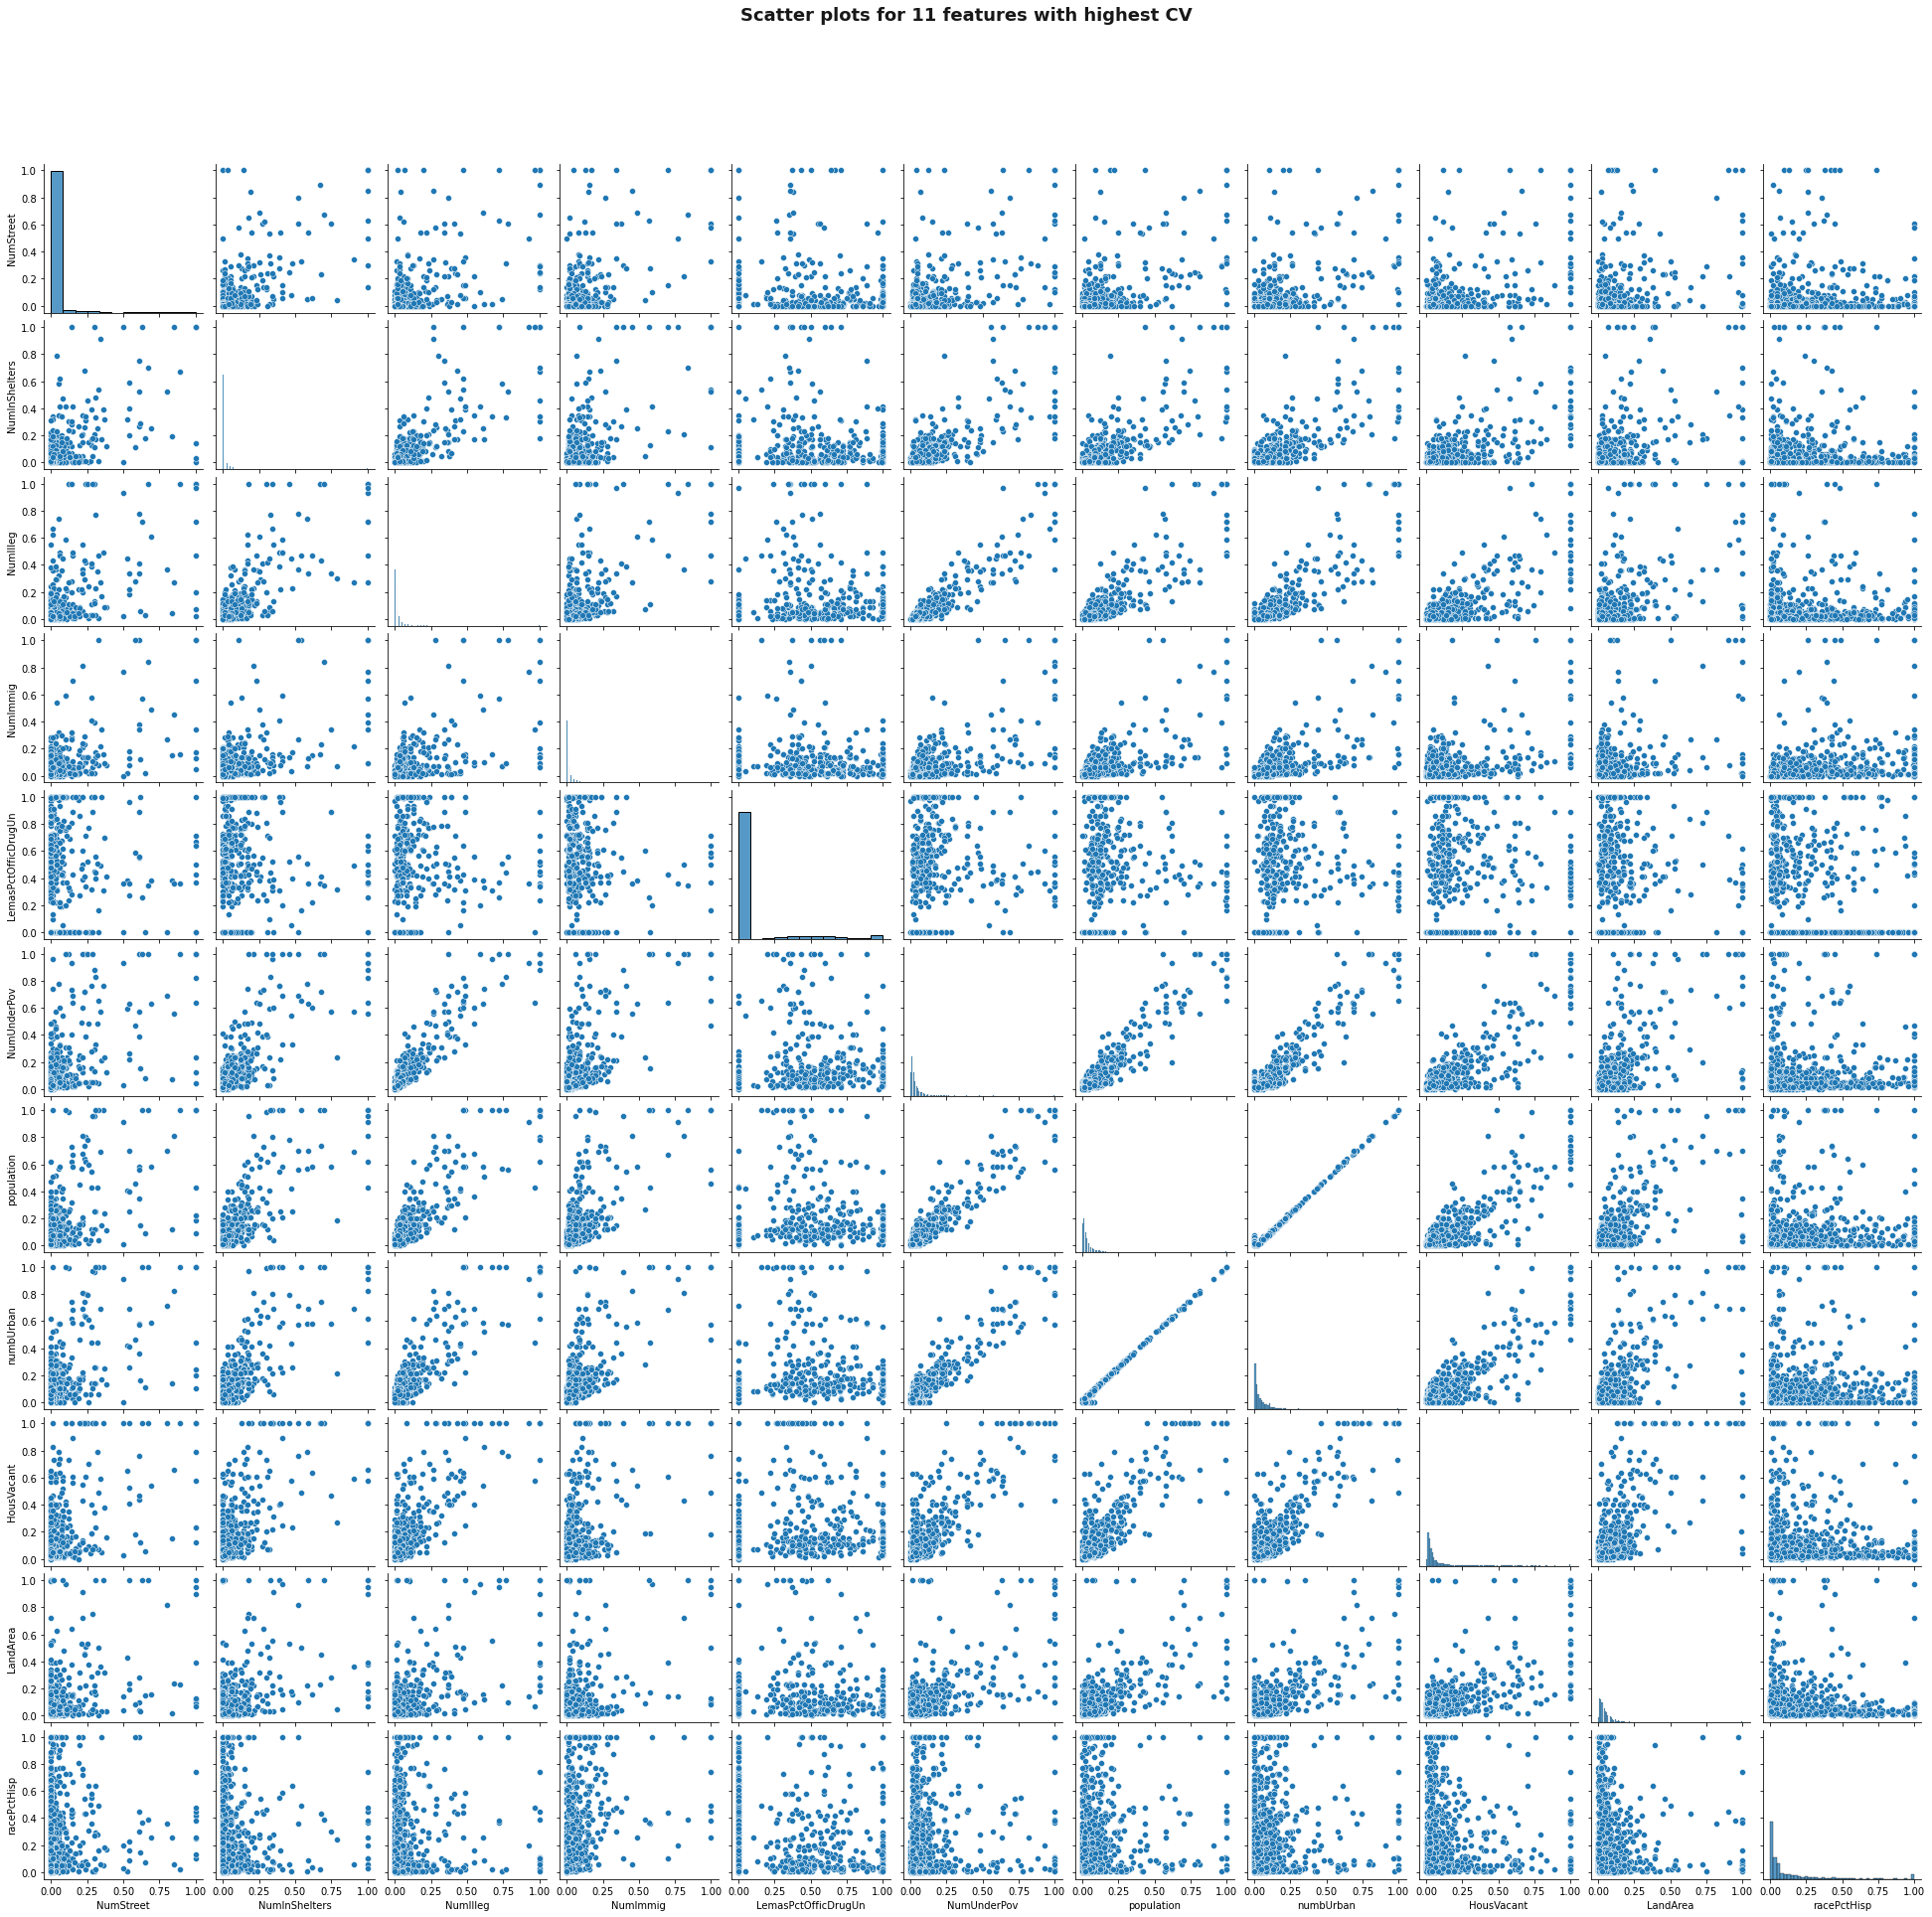

In [11]:
pairplot_fig = sns.pairplot(sel_combine)
plt.subplots_adjust(top=0.9)
pairplot_fig.fig.suptitle("Scatter plots for 11 features with highest CV", fontsize=18, alpha=0.9, weight='bold')
plt.show()

Text(0.5, 1.1, 'Boxplot for 11 features with the highest CV')

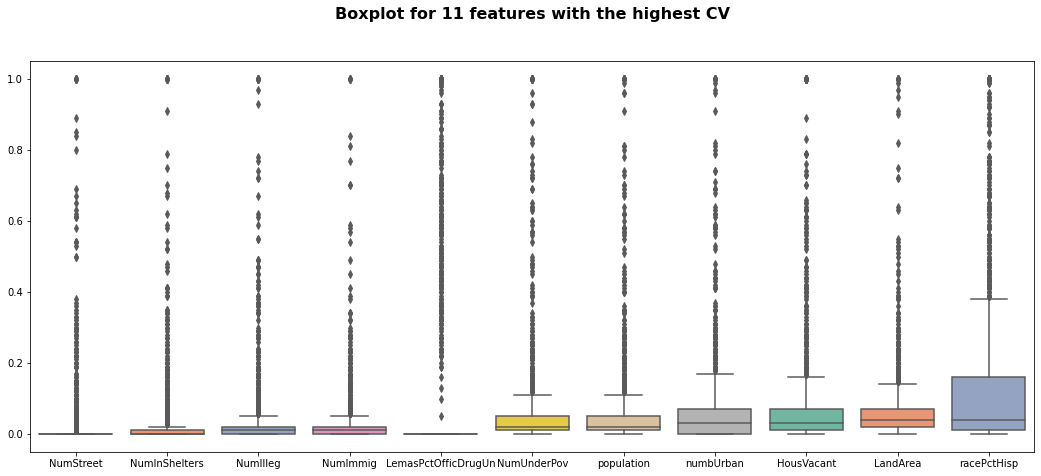

In [12]:
fig, ax = plt.subplots(figsize=(18,7))
sns.boxplot(data=sel_combine, orient="v", palette="Set2")
fig.subplots_adjust(top=0.9)
ax.text(x=0.5, y=1.1, s="Boxplot for 11 features with the highest CV", fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)


#### (f) Fit a linear model using least squares to the training set and report the test error.


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
X_train = c_train2.iloc[:,:-1]
y_train = c_train2.iloc[:,-1]
X_test = c_test2.iloc[:,:-1]
y_test = c_test2.iloc[:,-1]
reg = LinearRegression(normalize=True)
model = reg.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Coefficients: \n", reg.coef_)
print("Intercep: ", reg.intercept_)
print("MSE: ", mean_squared_error(y_test, y_pred))

Coefficients: 
 [-1.98855148e-02 -1.87458986e-02  2.78237806e-01  3.59131342e-03
 -4.22926593e-02  2.61253390e-02  1.93699417e-01 -3.34789490e-01
 -1.42253479e-01  7.22124350e-02 -1.25319232e-01  4.73680707e-02
 -1.77181529e-01 -1.29674026e-01  4.71451611e-02 -1.98146966e-01
  1.21954514e-01  6.02119109e-02 -1.18726015e-01  3.22820006e-01
 -5.32332810e-02 -2.05901324e-01 -5.21028098e-02 -4.51843694e-02
  2.69874549e-02  3.08746095e-02  3.58908862e-02  6.46579770e-02
 -2.04989927e-01 -6.06767084e-02  3.64900132e-02  9.77006520e-02
  3.06691279e-02  2.91516961e-01 -4.00239626e-02 -1.05886270e-02
  4.84237714e-02  6.64096855e-02  5.51444325e-01  2.41819378e-01
  2.17965333e-01 -7.30912596e-01 -1.00239735e-01 -6.08327026e-02
 -1.84995973e-01 -1.31557834e-02 -2.49512062e-02  5.83123941e-02
 -2.09651766e-01 -9.89351066e-02  6.58975604e-02 -1.41671903e-01
  6.66625168e-03  2.02455509e-02  5.97834188e-03 -2.15836969e-02
 -7.41528272e-02 -8.45397834e-03  7.38269529e-02  2.97765511e-02
 -3.68705

#### (g) Fit a ridge regression model on the training set, with λ chosen by cross-validation.Report the test error obtained.

In [14]:
from sklearn.linear_model import RidgeCV
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3], cv = 5)
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Coefficients: \n", clf.coef_)
print("Intercep: ", clf.intercept_)
print("Best alpha:", clf.alpha_)
print("MSE: ", mean_squared_error(y_test, y_pred))

Coefficients: 
 [-0.02218683  0.00533406  0.24770056 -0.02854747 -0.03525011  0.00488145
  0.07593574 -0.20005022 -0.05283692  0.05853129 -0.02381083  0.04417786
  0.04228882 -0.07944258  0.03607447 -0.13826381  0.07286816  0.0610478
 -0.11206067  0.05953785 -0.04317626 -0.10251048 -0.03041957 -0.03492375
  0.03091257  0.02848679  0.02870661 -0.01164272 -0.14569446 -0.05383706
  0.02577329  0.0446426  -0.00521168  0.17215477 -0.0387118  -0.00547298
  0.05240801  0.02928028  0.16076179  0.14217624 -0.10834193 -0.03717521
  0.04609569 -0.06324206 -0.13159801 -0.03938714 -0.02732264  0.0147366
 -0.14742415 -0.05573721  0.08929236 -0.08951767  0.00246973  0.00485005
  0.00205875 -0.01969917 -0.03106151  0.00067123  0.02873711  0.05924239
 -0.00287729 -0.10757545 -0.03673015 -0.08606616  0.1460053  -0.06741512
 -0.02795997 -0.11401979  0.20997409  0.08236733  0.01356093  0.1391517
 -0.06398655  0.034884    0.08350661 -0.07429544 -0.0166793   0.03334152
 -0.03137231 -0.07323674  0.03517054  

#### (h) Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model.Repeat with standardized2 features. Report the test error for both cases and compare them.

In [15]:
from sklearn.linear_model import LassoCV
las = LassoCV(cv=5, alphas= np.logspace(-5,5,11,base=10),max_iter=10000)
model = las.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Coefficients: \n", las.coef_)
print("Intercep: ", las.intercept_)
print("Best alpha:", las.alpha_)
print("MSE: ", mean_squared_error(y_test, y_pred))

Coefficients: 
 [-0.          0.          0.27305204 -0.         -0.01798214  0.
  0.07600145 -0.29112509  0.          0.00387318 -0.          0.04099461
  0.         -0.09316409  0.02905821 -0.11005721  0.0592378   0.04182285
 -0.10979718  0.         -0.         -0.06946044 -0.02254008 -0.03194572
  0.02923882  0.02361888  0.02570896 -0.         -0.15012476 -0.02130049
  0.          0.01731481 -0.          0.1550098  -0.01919701  0.
  0.01649189  0.          0.13263026  0.15069238 -0.0955719  -0.
  0.         -0.         -0.19812839 -0.03596962 -0.01153443  0.
 -0.13465667 -0.06233463  0.09557897 -0.08115944 -0.         -0.
 -0.         -0.00562052 -0.          0.          0.          0.03926042
 -0.         -0.08081295 -0.         -0.08945576  0.07330746 -0.
 -0.         -0.06435704  0.23109236  0.06485728  0.00596287  0.13029953
 -0.0595294   0.          0.07468566 -0.06286411 -0.0161948   0.0267917
 -0.02588767 -0.01886968 -0.         -0.         -0.16505491 -0.
  0.          0.173

#### (i) Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.

Best M : 95


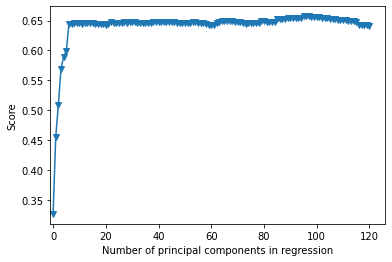

In [16]:
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
mse = []
for i in range(1,122):
    pca = PCA(n_components=i)
    model = pca.fit(X_train)
    pca_Xtrain = model.transform(X_train)
    
    kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=1)
    regr = LinearRegression()
    score = cross_val_score(regr, pca_Xtrain, y_train, cv=kf, n_jobs = -1).mean()
    mse.append(score)
plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('Score')
plt.xlim(xmin=-1);  
print("Best M :", np.argmax(mse))

In [17]:
print("Best M :", np.argmax(mse))

Best M : 95


In [18]:
pca = PCA(n_components=95)
model = pca.fit(X_train)
pca_Xtrain = model.transform(X_train)
pca_Xtest = model.transform(X_test)

regr = LinearRegression()
regr.fit(pca_Xtrain, y_train)

pred = regr.predict(pca_Xtest)
print("MSE :", mean_squared_error(y_test, pred))

MSE : 0.018490249808696534


#### (j) In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost3 to fit the model tree. Determine α (the regularization term) using cross-validation.

In [19]:
import xgboost as xgb

Best alphas : 0.1


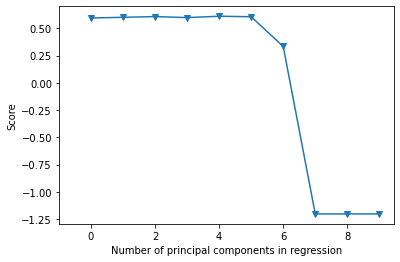

In [20]:
mse = []
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e1, 1e2, 1e3, 1e4, 1e5]
for i in alphas:
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror', max_depth = 5, reg_alpha = i, colsample_bytree = 0.7, learning_rate = 0.3)
    kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=1)
    score = cross_val_score(xg_reg, X_train, y_train, cv=kf).mean()
    mse.append(score)
plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('Score')
plt.xlim(xmin=-1);  
print("Best alphas :", alphas[np.argmax(mse)])   

In [21]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', max_depth = 5, reg_alpha = 10, colsample_bytree = 0.7, learning_rate = 0.3)
model = xg_reg.fit(X_train, y_train)

pred = xg_reg.predict(X_test)
print("MSE :", mean_squared_error(y_test, pred))

MSE : 0.018629233539686145


### 2. Tree-Based Methods

#### (a) Download the APS Failure data from: https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks . The dataset contains a training set and a test set. The training set contains 60,000 rows, of which 1,000 belong to the positive class and 171 columns, of which one is the class column. All attributes are numeric.

In [22]:
path2 = '/content/drive/MyDrive/HW4/Data/aps_failure_training_set.csv'
path3 = '/content/drive/MyDrive/HW4/Data/aps_failure_test_set.csv'
aps_train = pd.read_csv(path2, skiprows=20, header=0, sep=',') 
aps_test = pd.read_csv(path3, skiprows=20, header=0, sep=',')
aps_test

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0,20,12,0,0,0,0,0,2682,4736,3862,1846,0,0,0,3976,0,0,0,1520,2374,11516,9480,111258,470,0,0,0,0,58,26,0,0,0,0,0,0,0,...,0,6598,70,112,0,0,0,0,0,0,0,0,340,0,0,1100,574,232,66,780,882,0,4,0,0,0,465.5,90,7502,3156,1098,138,412,654,78,88,0,0,0,0
1,neg,82,0,68,40,0,0,0,0,0,0,748,12594,3636,0,0,0,5244,0,60,0,0,0,23174,18166,23686,1270,0,0,0,0,12,82,0,0,0,0,0,0,0,...,0,7918,78,40,0,0,0,0,0,0,0,0,352,0,0,3996,584,200,62,37580,3756,6368,36,0,0,0,2.86,102,10040,3310,1068,276,1620,116,86,462,0,0,0,0
2,neg,66002,2,212,112,0,0,0,0,0,199486,1358536,1952422,452706,25130,520,0,1891670,0,0,0,77898,110548,3605894,3291610,959756,286536,0,0,0,0,106,340,0,0,0,0,0,24286,681260,...,0,3613906,4218,692,0,0,0,0,0,0,0,0,25278,9438,2504,10262714,1278664,109700,19072,9520,4902,4434614,70900,0,0,26002880,2057.84,2158,396312,538136,495076,380368,440134,269556,1315022,153680,516,0,0,0
3,neg,59816,na,1010,936,0,0,0,0,0,0,123922,984314,1680050,1135268,92606,14038,1772828,0,0,0,1116,2372,3546760,3053176,652616,423374,0,0,7274,0,1622,432,0,0,0,0,0,6388,1091104,...,46,3413978,2924,414,0,0,60,38710,0,0,0,0,27740,33354,6330,0,0,133542,21290,2718360,435370,0,0,0,0,1179900,1541.32,1678,659550,691580,540820,243270,483302,485332,431376,210074,281662,3232,0,0
4,neg,1814,na,156,140,0,0,0,0,0,0,72,17926,82834,3114,0,0,48978,0,0,0,0,0,97146,89920,12932,5092,0,0,0,0,102,50,0,0,0,0,0,11544,73570,...,0,95372,78,36,0,0,0,0,0,0,0,0,538,360,142,0,0,1822,344,2140,394,13664,110,0,0,813740,113.86,52,10216,9958,7646,4144,18466,49782,3176,482,76,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,neg,81852,na,2130706432,892,0,0,0,0,0,0,5486,704012,3220278,1297498,76170,7206,2276100,0,0,0,0,0,4547950,3779700,973592,669608,0,0,1536,0,6374,1194,0,0,0,0,0,214014,3876498,...,12,4521542,4596,1006,0,0,0,0,0,0,0,0,40386,58588,23628,0,0,155596,23350,7124860,724280,30954,6854,0,0,10074490,1546.74,2054,883900,983308,632658,273242,510354,373918,349840,317840,960024,25566,0,0
15996,neg,18,0,52,46,8,26,0,0,0,0,6444,3308,2720,0,0,0,3740,0,0,0,1150,2790,14656,12242,7222,1338,0,0,0,0,66,96,0,0,0,0,0,0,0,...,0,3962,104,66,0,0,0,0,0,0,0,0,264,0,0,32,8,106,28,3500,340,11108,8,0,0,0,0.98,50,9354,2746,266,44,46,14,2,0,0,0,0,0
15997,neg,79636,na,1670,1518,0,0,0,0,0,0,15062,1991298,2768440,329148,13124,990,2156280,0,0,0,0,0,4562338,3828492,1238380,578006,0,0,1828,0,8044,1130,0,0,0,0,0,1686138,3101858,...,42,4728848,5108,456,0,0,0,0,0,0,0,0,40850,114166,18210,0,0,187506,29150,439500,51928,952030,7626,0,0,715020,3644.6,3982,450380,1073658,806832,449962,778826,581558,375498,222866,358934,19548,0,0
15998,neg,110,na,36,32,0,0,0,0,0,0,198,3730,27418,978,0,0,12790,0,0,0,0,0,26026,13504,61018,6160,0,0,0,0,22,66,0,0,0,0,0,0,0,...,0,12768,198,38,0,0,0,0,0,0,0,0,602,0,0,15122,2018,380,66,0,0,83504,100,0,0,0,133.84,130,22688,5698,588,210,180,544,1004,1338,74,0,0,0


#### (b) Data Preparation

#### This data set has missing values. When the number of data with missing values is significant, discarding them is not a good idea.

#### i. Research what types of techniques are usually used for dealing with data with missing values. Pick at least one of them and apply it to this data in the next steps.

In [23]:
aps_full = pd.concat([aps_train,aps_test], ignore_index=True)
aps_full

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,...,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,...,na,na,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,...,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,...,0,2578,76,62,0,0,0,0,0,0,0,0,232,0,0,2014,370,48,18,15740,1822,20174,44,0,0,0,1.08,54,5670,1566,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,0,43752,1966618,1800340,131646,4588,0,1974038,0,226,0,0,0,3230626,2618878,1058136,551022,0,0,0,0,1788,642,0,0,0,0,42124,372236,2128914,...,0,3590004,2026,444,0,0,0,0,0,0,0,0,44946,62648,11506,0,0,149474,35154,457040,80482,98334,27588,0,0,21173050,1116.06,1176,404740,904230,622012,229790,405298,347188,286954,311560,433954,1218,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75995,neg,81852,na,2130706432,892,0,0,0,0,0,0,5486,704012,3220278,1297498,76170,7206,2276100,0,0,0,0,0,4547950,3779700,973592,669608,0,0,1536,0,6374,1194,0,0,0,0,0,214014,3876498,...,12,4521542,4596,1006,0,0,0,0,0,0,0,0,40386,58588,23628,0,0,155596,23350,7124860,724280,30954,6854,0,0,10074490,1546.74,2054,883900,983308,632658,273242,510354,373918,349840,317840,960024,25566,0,0
75996,neg,18,0,52,46,8,26,0,0,0,0,6444,3308,2720,0,0,0,3740,0,0,0,1150,2790,14656,12242,7222,1338,0,0,0,0,66,96,0,0,0,0,0,0,0,...,0,3962,104,66,0,0,0,0,0,0,0,0,264,0,0,32,8,106,28,3500,340,11108,8,0,0,0,0.98,50,9354,2746,266,44,46,14,2,0,0,0,0,0
75997,neg,79636,na,1670,1518,0,0,0,0,0,0,15062,1991298,2768440,329148,13124,990,2156280,0,0,0,0,0,4562338,3828492,1238380,578006,0,0,1828,0,8044,1130,0,0,0,0,0,1686138,3101858,...,42,4728848,5108,456,0,0,0,0,0,0,0,0,40850,114166,18210,0,0,187506,29150,439500,51928,952030,7626,0,0,715020,3644.6,3982,450380,1073658,806832,449962,778826,581558,375498,222866,358934,19548,0,0
75998,neg,110,na,36,32,0,0,0,0,0,0,198,3730,27418,978,0,0,12790,0,0,0,0,0,26026,13504,61018,6160,0,0,0,0,22,66,0,0,0,0,0,0,0,...,0,12768,198,38,0,0,0,0,0,0,0,0,602,0,0,15122,2018,380,66,0,0,83504,100,0,0,0,133.84,130,22688,5698,588,210,180,544,1004,1338,74,0,0,0


In [24]:
cols = aps_full.columns.values.tolist()
missing = []
for i in cols:
    if 'na' in aps_full[i].values.tolist():
        missing.append(i)
        missing.append(aps_full[i].value_counts()['na']/76000)
missing

['ab_000',
 0.7722631578947369,
 'ac_000',
 0.05606578947368421,
 'ad_000',
 0.24792105263157896,
 'ae_000',
 0.041973684210526316,
 'af_000',
 0.041973684210526316,
 'ag_000',
 0.011315789473684211,
 'ag_001',
 0.011315789473684211,
 'ag_002',
 0.011315789473684211,
 'ag_003',
 0.011315789473684211,
 'ag_004',
 0.011315789473684211,
 'ag_005',
 0.011315789473684211,
 'ag_006',
 0.011315789473684211,
 'ag_007',
 0.011315789473684211,
 'ag_008',
 0.011315789473684211,
 'ag_009',
 0.011315789473684211,
 'ah_000',
 0.010789473684210526,
 'ai_000',
 0.010421052631578947,
 'aj_000',
 0.010421052631578947,
 'ak_000',
 0.0736578947368421,
 'al_000',
 0.010671052631578947,
 'am_0',
 0.010421052631578947,
 'an_000',
 0.010671052631578947,
 'ao_000',
 0.009881578947368422,
 'ap_000',
 0.010671052631578947,
 'aq_000',
 0.009881578947368422,
 'ar_000',
 0.04588157894736842,
 'as_000',
 0.010421052631578947,
 'at_000',
 0.010421052631578947,
 'au_000',
 0.010421052631578947,
 'av_000',
 0.041947368

In [25]:
aps_full1 = aps_full.replace('na', np.nan)
aps_full1

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,...,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,NaN,0,NaN,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,...,NaN,NaN,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,NaN,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,...,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,...,0,2578,76,62,0,0,0,0,0,0,0,0,232,0,0,2014,370,48,18,15740,1822,20174,44,0,0,0,1.08,54,5670,1566,240,46,58,44,10,0,0,0,4,32
4,neg,60874,NaN,1368,458,0,0,0,0,0,0,43752,1966618,1800340,131646,4588,0,1974038,0,226,0,0,0,3230626,2618878,1058136,551022,0,0,0,0,1788,642,0,0,0,0,42124,372236,2128914,...,0,3590004,2026,444,0,0,0,0,0,0,0,0,44946,62648,11506,0,0,149474,35154,457040,80482,98334,27588,0,0,21173050,1116.06,1176,404740,904230,622012,229790,405298,347188,286954,311560,433954,1218,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75995,neg,81852,NaN,2130706432,892,0,0,0,0,0,0,5486,704012,3220278,1297498,76170,7206,2276100,0,0,0,0,0,4547950,3779700,973592,669608,0,0,1536,0,6374,1194,0,0,0,0,0,214014,3876498,...,12,4521542,4596,1006,0,0,0,0,0,0,0,0,40386,58588,23628,0,0,155596,23350,7124860,724280,30954,6854,0,0,10074490,1546.74,2054,883900,983308,632658,273242,510354,373918,349840,317840,960024,25566,0,0
75996,neg,18,0,52,46,8,26,0,0,0,0,6444,3308,2720,0,0,0,3740,0,0,0,1150,2790,14656,12242,7222,1338,0,0,0,0,66,96,0,0,0,0,0,0,0,...,0,3962,104,66,0,0,0,0,0,0,0,0,264,0,0,32,8,106,28,3500,340,11108,8,0,0,0,0.98,50,9354,2746,266,44,46,14,2,0,0,0,0,0
75997,neg,79636,NaN,1670,1518,0,0,0,0,0,0,15062,1991298,2768440,329148,13124,990,2156280,0,0,0,0,0,4562338,3828492,1238380,578006,0,0,1828,0,8044,1130,0,0,0,0,0,1686138,3101858,...,42,4728848,5108,456,0,0,0,0,0,0,0,0,40850,114166,18210,0,0,187506,29150,439500,51928,952030,7626,0,0,715020,3644.6,3982,450380,1073658,806832,449962,778826,581558,375498,222866,358934,19548,0,0
75998,neg,110,NaN,36,32,0,0,0,0,0,0,198,3730,27418,978,0,0,12790,0,0,0,0,0,26026,13504,61018,6160,0,0,0,0,22,66,0,0,0,0,0,0,0,...,0,12768,198,38,0,0,0,0,0,0,0,0,602,0,0,15122,2018,380,66,0,0,83504,100,0,0,0,133.84,130,22688,5698,588,210,180,544,1004,1338,74,0,0,0


In [26]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(random_state=3, n_nearest_features=5)
imp.fit(aps_full1.iloc[:,1:])

aps_f = imp.transform(aps_full1.iloc[:,1:])
aps_f = pd.DataFrame(aps_f)
aps_f.columns = aps_full1.columns[1:]
X_train_aps = aps_f.iloc[:60000]
X_test_aps = aps_f.iloc[60000:]
X_train_aps

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698.0,0.931768,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,1432864.0,3664156.0,1007684.0,25896.0,0.0,2551696.0,0.0,0.0,0.0,0.0,0.0,4933296.0,3655166.0,1766008.0,1132040.0,0.0,0.0,0.0,0.0,1012.0,268.0,0.0,0.0,0.0,0.0,0.0,469014.0,4239660.0,703300.0,...,18.00000,5.330690e+06,4732.0,1126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62282.0,85908.0,32790.0,0.0,0.0,202710.0,37928.0,14745580.0,1876644.0,0.0,0.0,0.0,0.0,2801180.0,2445.80,2712.0,965866.0,1706908.0,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,33058.0,0.697096,0.000000e+00,150982.523354,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,653294.0,1720800.0,516724.0,31642.0,0.0,1393352.0,0.0,68.0,0.0,0.0,0.0,2560898.0,2127150.0,1084598.0,338544.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71510.0,772720.0,1996924.0,...,14.09543,2.506508e+06,3312.0,522.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33736.0,36946.0,5936.0,0.0,0.0,103330.0,16254.0,4510080.0,868538.0,0.0,0.0,0.0,0.0,3477820.0,2211.76,2334.0,664504.0,824154.0,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,41040.0,0.704131,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,1648.0,370592.0,1883374.0,292936.0,12016.0,0.0,1234132.0,0.0,0.0,0.0,0.0,0.0,2371990.0,2173634.0,300796.0,153698.0,0.0,0.0,0.0,0.0,358.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,870456.0,239798.0,...,0.00000,2.341048e+06,1494.0,152.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13876.0,38182.0,8138.0,0.0,0.0,65772.0,10534.0,300240.0,48028.0,0.0,0.0,0.0,0.0,1040120.0,1018.64,1020.0,262032.0,453378.0,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,12.0,0.000000,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,318.0,2212.0,3232.0,1872.0,0.0,0.0,0.0,2668.0,0.0,0.0,0.0,642.0,3894.0,10184.0,7554.0,10764.0,1014.0,0.0,0.0,0.0,0.0,60.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2038.0,...,0.00000,2.578000e+03,76.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,232.0,0.0,0.0,2014.0,370.0,48.0,18.0,15740.0,1822.0,20174.0,44.0,0.0,0.0,0.0,1.08,54.0,5670.0,1566.0,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,60874.0,0.780256,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,43752.0,1966618.0,1800340.0,131646.0,4588.0,0.0,1974038.0,0.0,226.0,0.0,0.0,0.0,3230626.0,2618878.0,1058136.0,551022.0,0.0,0.0,0.0,0.0,1788.0,642.0,0.0,0.0,0.0,0.0,42124.0,372236.0,2128914.0,819596.0,...,0.00000,3.590004e+06,2026.0,444.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44946.0,62648.0,11506.0,0.0,0.0,149474.0,35154.0,457040.0,80482.0,98334.0,27588.0,0.0,0.0,21173050.0,1116.06,1176.0,404740.0,904230.0,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,153002.0,1.156404,6.640000e+02,186.000000,0.0,0.0,0.0,0.0,0.0,2564.0,59100.0,1603216.0,6015982.0,1968266.0,164972.0,12560.0,4880368.0,0.0,280.0,0.0,1224.0,2114.0,8913782.0,7998174.0,1929126.0,776370.0,2.0,0.0,0.0,0.0,3328.0,1080.0,0.0,0.0,0.0,0.0,0.0,45114.0,2533260.0,2542338.0,...,0.00000,1.872932e+06,4936.0,1600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62846.0,137050.0,27546.0,0.0,0.0,265640.0,54496.0,470800.0,293652.0,0.0,0.0,0.0,0.0,80125300.0,2912.04,2858.0,1608808.0,1479066.0,998500.0,566884.0,1290398.0,1218244.0,1019768

#### ii. For each of the 170 features, calculate the coefficient of variation CV = s/m, where s is sample standard deviation and m is sample mean.

In [27]:
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100 
CV = pd.DataFrame(X_train_aps.apply(cv))
CV.columns = ['CV']
CV

,CV
aa_000,245.093758
ab_000,222.281248
ac_000,218.296146
ad_000,19376.274019
ae_000,2080.340027
...,...
ee_007,498.606949
ee_008,322.985313
ee_009,563.035621
ef_000,4437.656027


#### iii. Plot a correlation matrix for your features using pandas or any other tool.

In [28]:
corrMatrix = X_train_aps.corr()
plt.figure(figsize=(100,100))
sns.heatmap(corrMatrix, annot=True)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### iv. Pick √170 features with highest CV , and make scatter plots and box plots for them, similar to those on p. 129 of ISLR. Can you draw conclusions about significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following questions. We picked them only for visualization.

In [29]:
cv_sort = CV.sort_values(by = ['CV'], ascending=False)
list_index = cv_sort.index.tolist()
sel_col = list_index[:round(170**0.5)]
sel_aps_t = X_train_aps.loc[:,sel_col]
sel_aps_t

,cs_009,cf_000,co_000,ad_000,ag_000,dj_000,as_000,ay_009,az_009,dh_000,au_000,ay_001,cs_008
0,0.0,2.00000,220.00000,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118.0
1,0.0,150608.68215,150896.63706,150982.523354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
2,0.0,0.00000,0.00000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,246.0
3,0.0,2.00000,2.00000,66.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.00000,202.00000,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.00000,224.00000,186.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122.0
59996,0.0,2.00000,0.00000,224.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,196.0
59997,0.0,2.00000,0.00000,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59998,0.0,2.00000,580.00000,494.000000,0.0,0.0,0.0,0.0,0.0,190.0,0.0,0.0,56.0


In [30]:
sel_aps_t['class'] = aps_train.loc[:,'class']
sel_aps_t

,cs_009,cf_000,co_000,ad_000,ag_000,dj_000,as_000,ay_009,az_009,dh_000,au_000,ay_001,cs_008,class
0,0.0,2.00000,220.00000,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118.0,neg
1,0.0,150608.68215,150896.63706,150982.523354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,neg
2,0.0,0.00000,0.00000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,246.0,neg
3,0.0,2.00000,2.00000,66.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neg
4,0.0,0.00000,202.00000,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,neg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.00000,224.00000,186.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122.0,neg
59996,0.0,2.00000,0.00000,224.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,196.0,neg
59997,0.0,2.00000,0.00000,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neg
59998,0.0,2.00000,580.00000,494.000000,0.0,0.0,0.0,0.0,0.0,190.0,0.0,0.0,56.0,neg


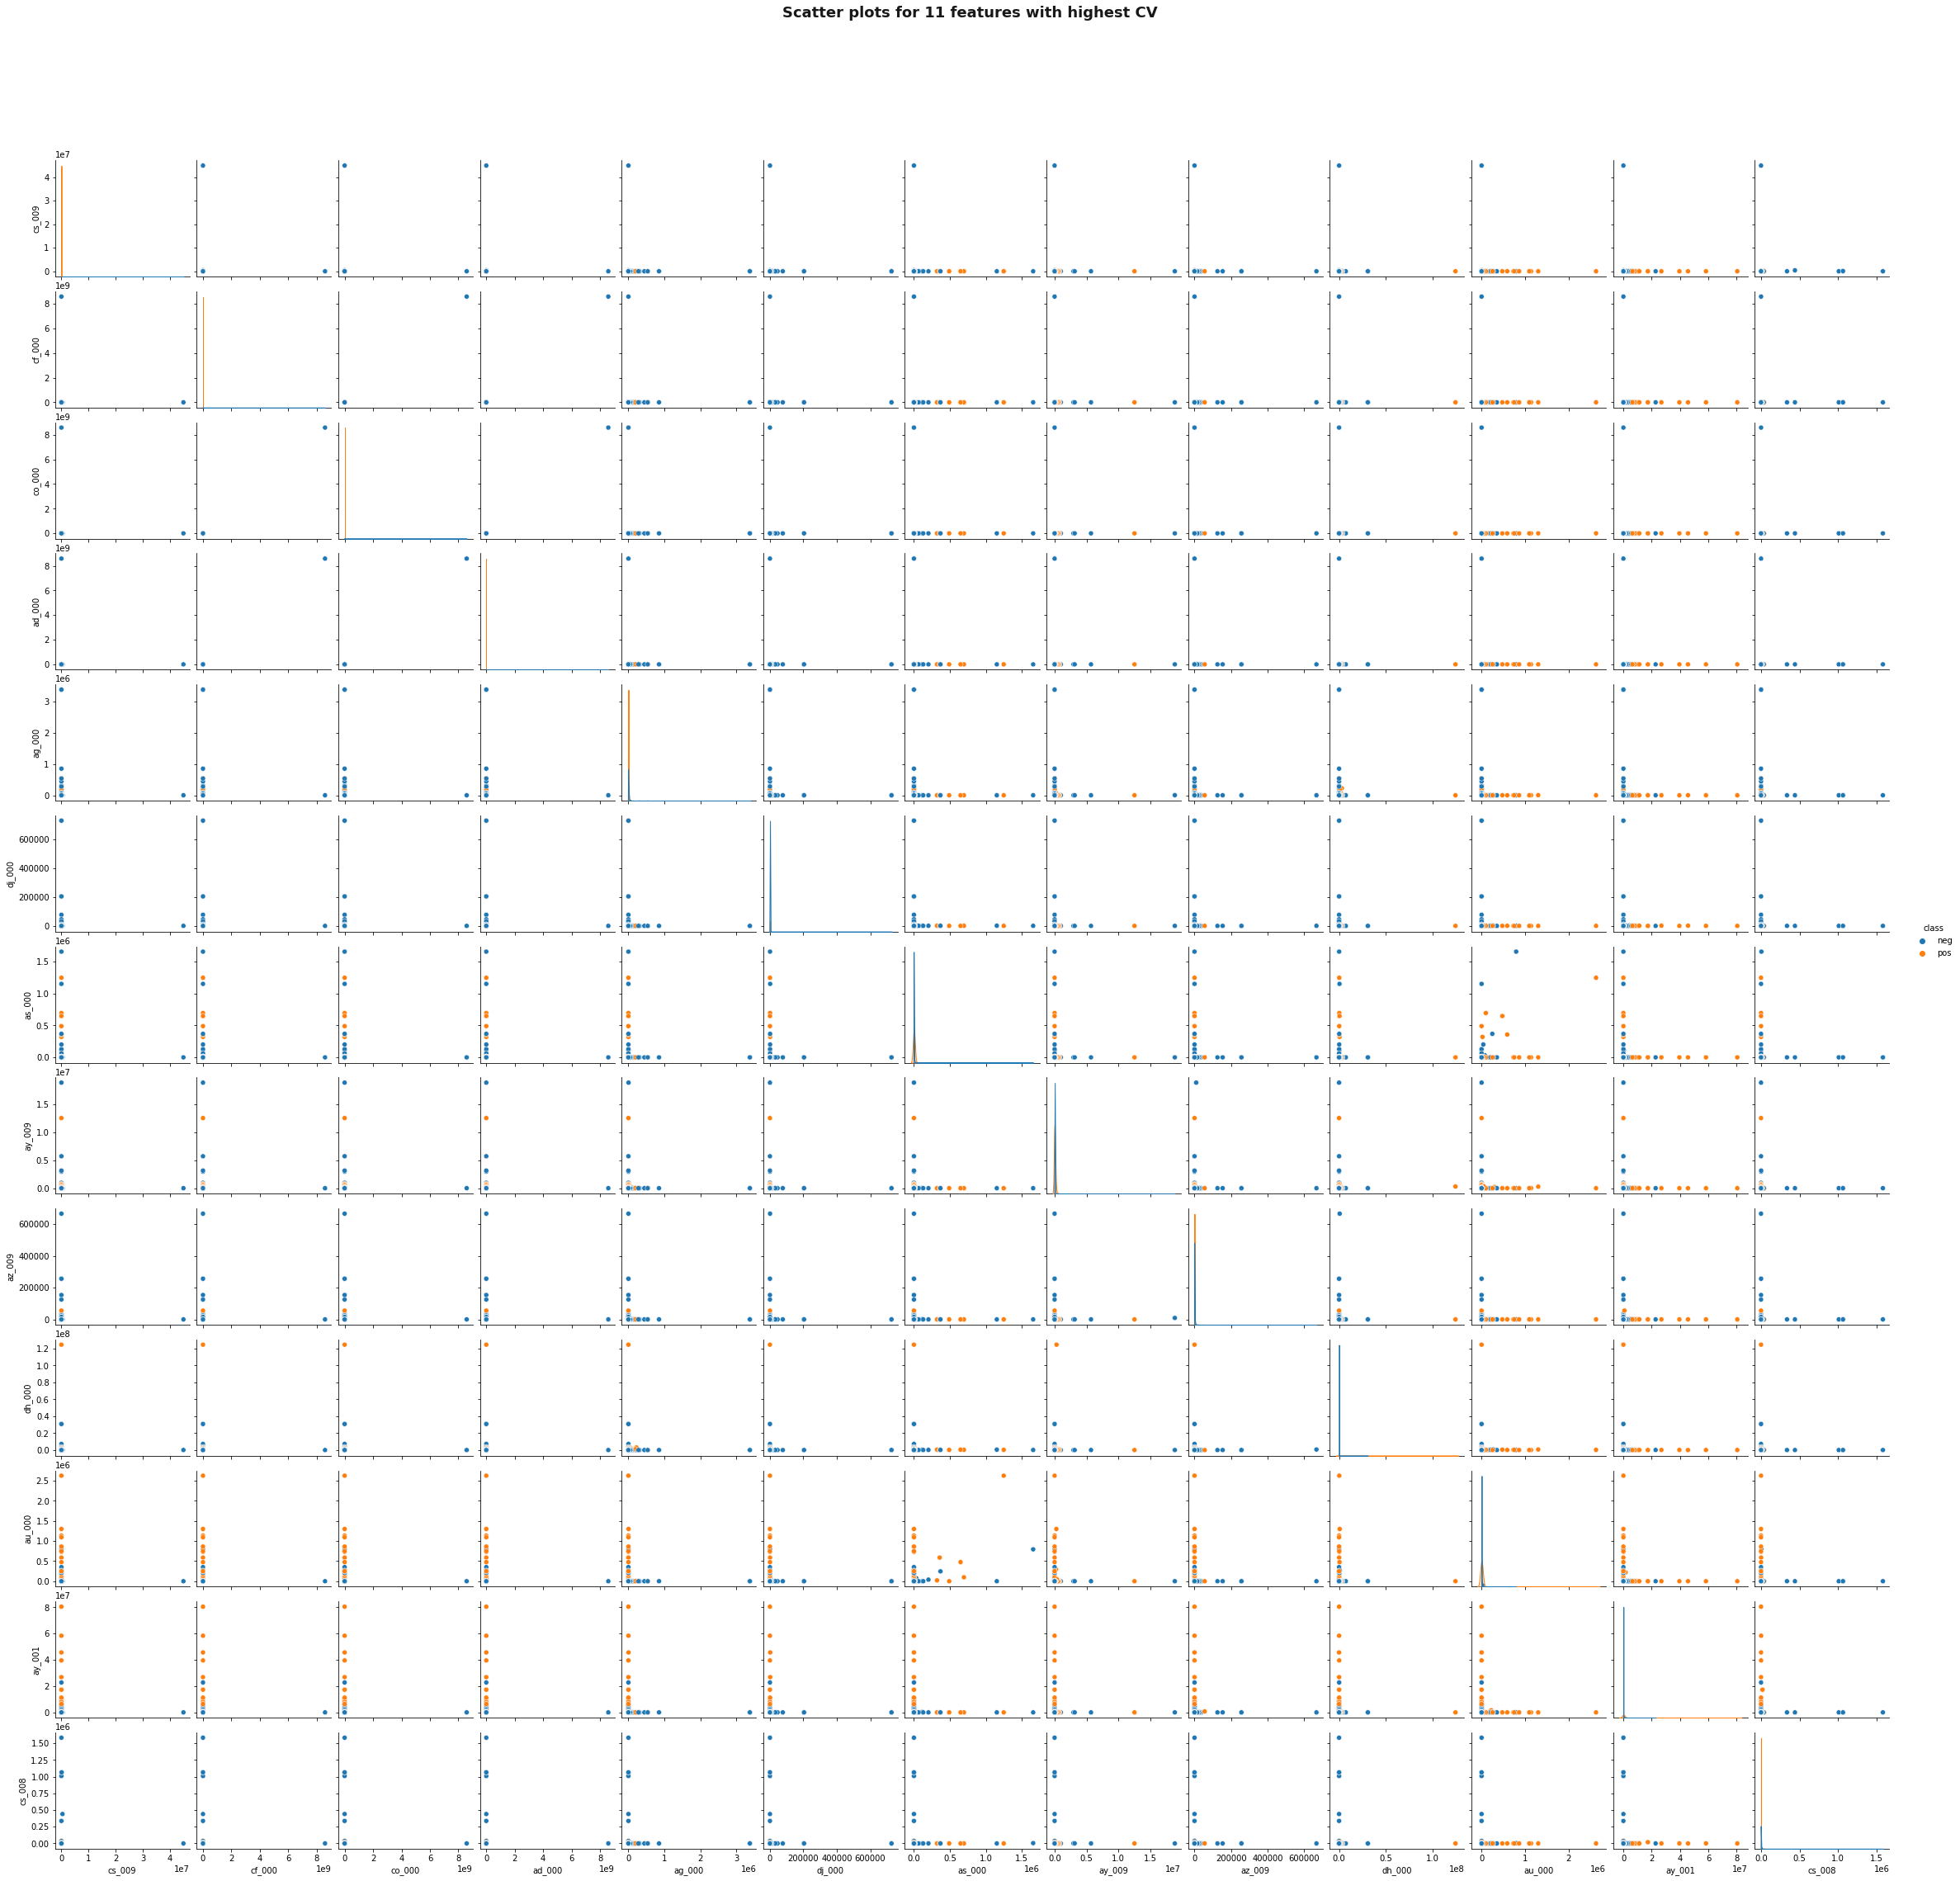

In [31]:
pairplot_fig = sns.pairplot(sel_aps_t, hue = 'class')
plt.subplots_adjust(top=0.9)
pairplot_fig.fig.suptitle("Scatter plots for 11 features with highest CV", fontsize=18, alpha=0.9, weight='bold')
plt.show()

Text(0.5, 0.98, 'Boxplot for 13 features with the highest CV')

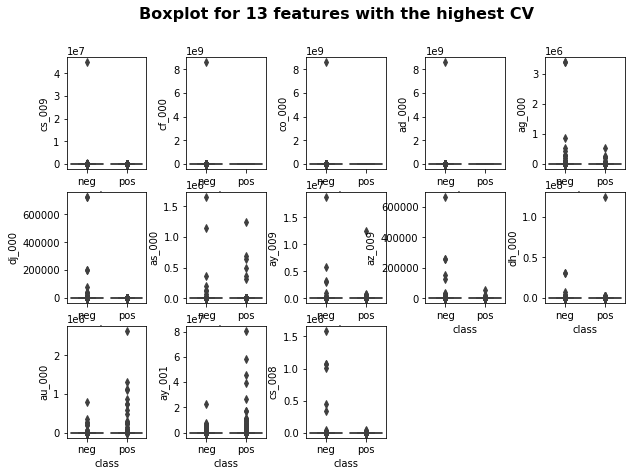

In [32]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
x = "class"
y1 = "cs_009"
y2 = "cf_000"
y3 = "co_000"
y4 = "ad_000"
y5 = "ag_000"
y6 = "dj_000"
y7 = "as_000"
y8 = "ay_009"
y9 = "az_009"
y10 = "dh_000"
y11 = "au_000"
y12 = "ay_001"
y13 = "cs_008"
# Create the canvas and subplots
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(3, 5, 1)
sns.boxplot(x, y1, data=sel_aps_t)
ax2 = fig.add_subplot(3, 5, 2)
sns.boxplot(x, y2, data=sel_aps_t)
ax3 = fig.add_subplot(3, 5, 3)
sns.boxplot(x, y3, data=sel_aps_t)
ax4 = fig.add_subplot(3, 5, 4)
sns.boxplot(x, y4, data=sel_aps_t)
ax5 = fig.add_subplot(3, 5, 5)
sns.boxplot(x, y5, data=sel_aps_t)
ax6 = fig.add_subplot(3, 5, 6)
sns.boxplot(x, y6, data=sel_aps_t)
ax7 = fig.add_subplot(3, 5, 7)
sns.boxplot(x, y7, data=sel_aps_t)
ax8 = fig.add_subplot(3, 5, 8)
sns.boxplot(x, y8, data=sel_aps_t)
ax9 = fig.add_subplot(3, 5, 9)
sns.boxplot(x, y9, data=sel_aps_t)
ax10 = fig.add_subplot(3, 5, 10)
sns.boxplot(x, y10, data=sel_aps_t)
ax11 = fig.add_subplot(3, 5, 11)
sns.boxplot(x, y11, data=sel_aps_t)
ax12 = fig.add_subplot(3, 5, 12)
sns.boxplot(x, y12, data=sel_aps_t)
ax13 = fig.add_subplot(3, 5, 13)
sns.boxplot(x, y13, data=sel_aps_t)
fig.subplots_adjust(wspace = 0.5, hspace = 0.2 )
fig.suptitle("Boxplot for 13 features with the highest CV", fontsize=16, weight='bold')

#### v. Determine the number of positive and negative data. Is this data set imbalanced?

In [33]:
clas = ['neg', 'pos']
count = []
for i in clas:
  count.append(aps_full1['class'].value_counts()[i])
count


[74625, 1375]

#### There are 1375 positive data and 74625 negative data and negative data is a large number of bigger than postive data. So the data set is imbalanced.

#### (c) Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forset and compare it to the test error.

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

y_trainn = aps_train.loc[:,'class']
y_trainn1 = y_trainn.replace('neg', 0)
y_trainn2 = y_trainn1.replace('pos', 1)

X_testt = X_test_aps
y_testt = aps_test.loc[:,'class']
y_testt1 = y_testt.replace('neg', 0)
y_testt2 = y_testt1.replace('pos', 1)

clf = RandomForestClassifier(max_depth=5, random_state=5, oob_score=True)
clf.fit(X_train_aps,y_trainn2)

y_pred1 = clf.predict(X_train_aps)
cm1 = confusion_matrix(y_trainn2, y_pred1)
cm1

array([[58966,    34],
       [  442,   558]])

In [35]:
y_pred2 = clf.predict(X_test_aps)
cm2 = confusion_matrix(y_testt2, y_pred2)
cm2

array([[15607,    18],
       [  177,   198]])

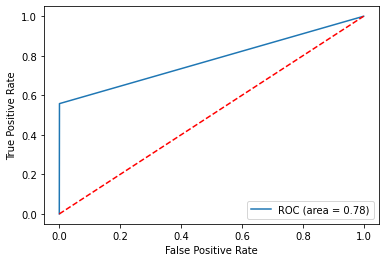

The AUC score : 0.7787118644067796


In [36]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_trainn2, y_pred1)
fpr, tpr, thresholds = roc_curve(y_trainn2, y_pred1)
plt.figure()
plt.plot(fpr, tpr, label='ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()
print('The AUC score :', roc_auc)

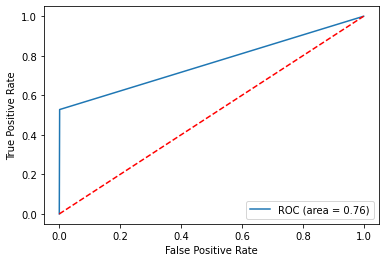

The AUC score : 0.763424


In [37]:
roc_auc = roc_auc_score(y_testt2, y_pred2)
fpr, tpr, thresholds = roc_curve(y_testt2, y_pred2)
plt.figure()
plt.plot(fpr, tpr, label='ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()
print('The AUC score :', roc_auc)

In [38]:
from sklearn.metrics import accuracy_score
print('Misclassification:', 1-accuracy_score(y_testt2, y_pred2))

Misclassification: 0.012187500000000018


In [39]:
print('Out of Bag erro:',1 - clf.oob_score_)

Out of Bag erro: 0.009416666666666629


#### The out of bag error has a similar value with the test error.

(d) Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 2c. Compare the results with those of 2c.

In [40]:
y_trainn = aps_train.loc[:,'class']
y_trainn1 = y_trainn.replace('neg', 0)
y_trainn2 = y_trainn1.replace('pos', 1)

X_testt = X_test_aps
y_testt = aps_test.loc[:,'class']
y_testt1 = y_testt.replace('neg', 0)
y_testt2 = y_testt1.replace('pos', 1)

clf = RandomForestClassifier(max_depth=5, random_state=5, oob_score=True, class_weight='balanced_subsample')
clf.fit(X_train_aps,y_trainn2)

y_pred1 = clf.predict(X_train_aps)
cm1 = confusion_matrix(y_trainn2, y_pred1)
cm1

array([[56603,  2397],
       [   29,   971]])

In [41]:
y_pred2 = clf.predict(X_test_aps)
cm2 = confusion_matrix(y_testt2, y_pred2)
cm2

array([[15006,   619],
       [   16,   359]])

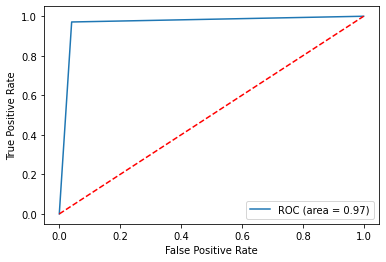

The AUC score : 0.9651864406779661


In [42]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_trainn2, y_pred1)
fpr, tpr, thresholds = roc_curve(y_trainn2, y_pred1)
plt.figure()
plt.plot(fpr, tpr, label='ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()
print('The AUC score :', roc_auc)

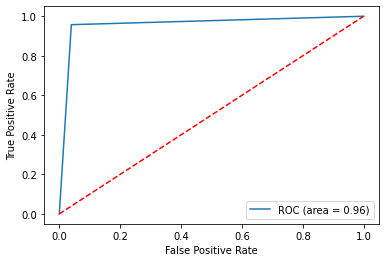

The AUC score : 0.9588586666666667


In [43]:
roc_auc = roc_auc_score(y_testt2, y_pred2)
fpr, tpr, thresholds = roc_curve(y_testt2, y_pred2)
plt.figure()
plt.plot(fpr, tpr, label='ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()
print('The AUC score :', roc_auc)

In [44]:
from sklearn.metrics import accuracy_score
print('Misclassification:', 1-accuracy_score(y_testt2, y_pred2))

Misclassification: 0.03968749999999999


In [45]:
print('Out of Bag erro:',1 - clf.oob_score_)

Out of Bag erro: 0.04149999999999998


#### When compensate for class imbalanced in random forest, the value of AUC has improved from 0.76 to 0.96

#### (e) Model Trees 
In the case of a univariate tree, only one input dimension is used at a tree split. In a multivariate tree, or model tree, at a decision node all input dimensions can be used and thus it is more general. In univariate classication trees, majority polling is used at each node to determine the split of that node as the decision rule. In model trees, a (linear) model that relies on all of the variables is used to determine the split of that node (i.e. instead of using Xj > s as the decision
rule, one has sumBjXj > s. as the decision rule). Alternatively, in a regression tree, instead of using average in the region associated with each node, a linear regression model is used to determine the value associated with that node. One of the methods that can be used at each node is Logistic Regression. One can use scikit learn to call Weka7 to train Logistic Model Trees for classication. Train Logistic Model Trees for the APS data set without compensation for class imbalance. Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model and compare it with the test error. Report the Confusion Matrix, ROC, and AUC for training and test sets.

In [46]:
!pip install python-weka-wrapper3

     |████████████████████████████████| 12.9 MB 6.7 MB/s 
     |████████████████████████████████| 1.3 MB 47.1 MB/s 
  Created wheel for python-weka-wrapper3: filename=python_weka_wrapper3-0.2.3-py3-none-any.whl size=11540516 sha256=1ff0e5794540b30ae6a95ff1e4f76e821a8ac137b74299c011f0d1d8683b9d6e
  Stored in directory: /root/.cache/pip/wheels/95/b9/7e/ea917497d6769b8b5a025c7509ef7f1c4e4da4d53621aef3e6
  Created wheel for javabridge: filename=javabridge-1.0.19-cp37-cp37m-linux_x86_64.whl size=1636657 sha256=2b35532ea43f7b6b47d50aabb56857692e2ad3afc2432e6337bfcc1f3ce2603a
  Stored in directory: /root/.cache/pip/wheels/8b/5e/7f/e1dd610613dcde4a4ed2974b4208ba90247a2dfc9add216c59
Successfully built python-weka-wrapper3 javabridge


In [47]:
import weka.core.jvm as jvm
import javabridge
jvm.start(packages=True)

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/usr/local/lib/python3.7/dist-packages/javabridge/jars/rhino-1.7R4.jar', '/usr/local/lib/python3.7/dist-packages/javabridge/jars/runnablequeue.jar', '/usr/local/lib/python3.7/dist-packages/javabridge/jars/cpython.jar', '/usr/local/lib/python3.7/dist-packages/weka/lib/python-weka-wrapper.jar', '/usr/local/lib/python3.7/dist-packages/weka/lib/weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support disabled


In [67]:
weka_train = pd.concat([X_train_aps, aps_train.loc[:,'class']],axis=1)
#weka_test = pd.concat([X_test_aps, aps_test.loc[:,'class']],axis=1)
weka_train.to_csv('/content/drive/MyDrive/HW4/Data/weka_train.csv',index=False)
#weka_test.to_csv('/content/drive/MyDrive/HW4/Data/weka_test.csv',index=False)

In [49]:
from weka.core.converters import Loader

In [68]:
from weka.core.converters import Loader
weka_load = Loader(classname='weka.core.converters.CSVLoader')
weka_train = weka_load.load_file('/content/drive/MyDrive/HW4/Data/weka_train.csv')
#weka_test = weka_load.load_file('/content/drive/MyDrive/HW4/Data/weka_test.csv')
weka_train.class_is_last()
#weka_test.class_is_last()

In [51]:
from weka.classifiers import Classifier
from weka.classifiers import Evaluation
from weka.core.classes import Random

In [52]:
# 5 Folds
cls = Classifier(classname="weka.classifiers.trees.LMT")
eval = Evaluation(weka_train)
eval.crossvalidate_model(cls, weka_train, num_folds=5, rnd=Random(5))
print(eval.confusion_matrix)
print(eval.summary())
print(eval.class_details())

[[58825.   175.]
 [  304.   696.]]

Correctly Classified Instances       59521               99.2017 %
Incorrectly Classified Instances       479                0.7983 %
Kappa statistic                          0.74  
Mean absolute error                      0.0106
Root mean squared error                  0.0815
Relative absolute error                 32.404  %
Root relative squared error             63.6799 %
Total Number of Instances            60000     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.997    0.304    0.995      0.997    0.996      0.742    0.956     0.997     neg
                 0.696    0.003    0.799      0.696    0.744      0.742    0.956     0.766     pos
Weighted Avg.    0.992    0.299    0.992      0.992    0.992      0.742    0.956     0.993     



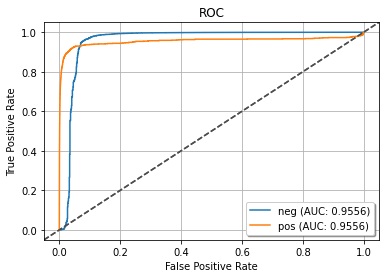

In [53]:
import weka.plot.classifiers
weka.plot.classifiers.plot_roc(eval, class_index=[0,1],wait=True)

In [54]:
cls.build_classifier(weka_train)
weka_test_pre = []
weka_test_pro = []
for i in weka_test:
  weka_test_pre.append(cls.classify_instance(i))
  weka_test_pro.append(cls.distribution_for_instance(i))
weka_test_pre = np.array(weka_test_pre).astype('str')
weka_test_pre[weka_test_pre == '0.0'] = 'neg'
weka_test_pre[weka_test_pre == '1.0'] = 'pos'
weka_test_pro = np.array(weka_test_pro)


In [79]:
X_test_aps.index=aps_test.index
X_test_aps

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,60.0,0.000000,2.000000e+01,12.0,0.0,0.0,0.0,0.0,0.0,2682.0,4736.0,3862.0,1846.0,0.0,0.0,0.0,3976.0,0.0,0.0,0.0,1520.0,2374.0,11516.0,9480.0,111258.0,470.0,0.0,0.0,0.0,0.0,58.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,6598.0,70.0,112.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,340.0,0.0,0.0,1100.0,574.0,232.0,66.0,780.0,882.0,0.0,4.0,0.0,0.0,0.0,465.50,90.0,7502.0,3156.0,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,82.0,0.000000,6.800000e+01,40.0,0.0,0.0,0.0,0.0,0.0,0.0,748.0,12594.0,3636.0,0.0,0.0,0.0,5244.0,0.0,60.0,0.0,0.0,0.0,23174.0,18166.0,23686.0,1270.0,0.0,0.0,0.0,0.0,12.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,692.0,...,0.0,7918.0,78.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,352.0,0.0,0.0,3996.0,584.0,200.0,62.0,37580.0,3756.0,6368.0,36.0,0.0,0.0,0.0,2.86,102.0,10040.0,3310.0,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,66002.0,2.000000,2.120000e+02,112.0,0.0,0.0,0.0,0.0,0.0,199486.0,1358536.0,1952422.0,452706.0,25130.0,520.0,0.0,1891670.0,0.0,0.0,0.0,77898.0,110548.0,3605894.0,3291610.0,959756.0,286536.0,0.0,0.0,0.0,0.0,106.0,340.0,0.0,0.0,0.0,0.0,0.0,24286.0,681260.0,2808472.0,...,0.0,3613906.0,4218.0,692.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25278.0,9438.0,2504.0,10262714.0,1278664.0,109700.0,19072.0,9520.0,4902.0,4434614.0,70900.0,0.0,0.0,26002880.0,2057.84,2158.0,396312.0,538136.0,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,59816.0,0.744258,1.010000e+03,936.0,0.0,0.0,0.0,0.0,0.0,0.0,123922.0,984314.0,1680050.0,1135268.0,92606.0,14038.0,1772828.0,0.0,0.0,0.0,1116.0,2372.0,3546760.0,3053176.0,652616.0,423374.0,0.0,0.0,7274.0,0.0,1622.0,432.0,0.0,0.0,0.0,0.0,0.0,6388.0,1091104.0,2930694.0,...,46.0,3413978.0,2924.0,414.0,0.0,0.0,60.0,38710.0,0.0,0.0,0.0,0.0,27740.0,33354.0,6330.0,0.0,0.0,133542.0,21290.0,2718360.0,435370.0,0.0,0.0,0.0,0.0,1179900.0,1541.32,1678.0,659550.0,691580.0,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,1814.0,0.601111,1.560000e+02,140.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,17926.0,82834.0,3114.0,0.0,0.0,48978.0,0.0,0.0,0.0,0.0,0.0,97146.0,89920.0,12932.0,5092.0,0.0,0.0,0.0,0.0,102.0,50.0,0.0,0.0,0.0,0.0,0.0,11544.0,73570.0,3662.0,...,0.0,95372.0,78.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,538.0,360.0,142.0,0.0,0.0,1822.0,344.0,2140.0,394.0,13664.0,110.0,0.0,0.0,813740.0,113.86,52.0,10216.0,9958.0,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,81852.0,0.840571,2.130706e+09,892.0,0.0,0.0,0.0,0.0,0.0,0.0,5486.0,704012.0,3220278.0,1297498.0,76170.0,7206.0,2276100.0,0.0,0.0,0.0,0.0,0.0,4547950.0,3779700.0,973592.0,669608.0,0.0,0.0,1536.0,0.0,6374.0,1194.0,0.0,0.0,0.0,0.0,0.0,214014.0,3876498.0,868212.0,...,12.0,4521542.0,4596.0,1006.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40386.0,58588.0,23628.0,0.0,0.0,155596.0,23350.0,7124860.0,724280.0,30954.0,6854.0,0.0,0.0,10074490.0,1546.74,2054.0,883900.0,983308.0,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
15996,18.0,0.000000,5.200000e+01,46.0,8.0,26.0,0.0,0.0,0.0,0.0,6444.0,3308.0,2720.0,0.0,0.0,0.0,3740.0,0.0,0.0,0.0,1150.0,2790.0,14656.0,12242.0,7222.0,1338.0,0.0,0.0,0.0,0.0,66.0,

In [84]:
weka_test = pd.concat([X_test_aps, aps_test.loc[:,'class']],axis=1)
weka_test.to_csv('/content/drive/MyDrive/HW4/Data/weka_test.csv',index=False)


In [85]:
weka_test = weka_load.load_file('/content/drive/MyDrive/HW4/Data/weka_test.csv')
weka_test.class_is_last()

In [86]:
weka_test_pre = []
weka_test_pro = []
for i in weka_test:
  weka_test_pre.append(cls.classify_instance(i))
  weka_test_pro.append(cls.distribution_for_instance(i))
weka_test_pre = np.array(weka_test_pre).astype('str')
weka_test_pre[weka_test_pre == '0.0'] = 'neg'
weka_test_pre[weka_test_pre == '1.0'] = 'pos'
weka_test_pro = np.array(weka_test_pro)


In [87]:
print('Confusion Matrix for Test:')
print(confusion_matrix(aps_test.loc[:,'class'], weka_test_pre))

Confusion Matrix for Test:
[[15589    36]
 [  110   265]]


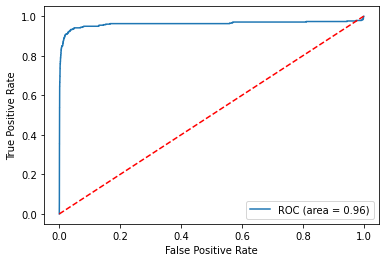

The AUC score for Test: 0.9612475733333333


In [96]:
fpr, tpr, thresholds = roc_curve(aps_test.loc[:,'class'], weka_test_pro[:,1],pos_label='pos')
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()
print('The AUC score for Test:', roc_auc)

In [90]:
# 10 Folds
cls = Classifier(classname="weka.classifiers.trees.LMT")
eval1 = Evaluation(weka_train)
eval1.crossvalidate_model(cls, weka_train, num_folds=10, rnd=Random(5))
print(eval1.confusion_matrix)
print(eval1.summary())
print(eval1.class_details())


[[58834.   166.]
 [  286.   714.]]

Correctly Classified Instances       59548               99.2467 %
Incorrectly Classified Instances       452                0.7533 %
Kappa statistic                          0.7558
Mean absolute error                      0.0102
Root mean squared error                  0.079 
Relative absolute error                 31.0723 %
Root relative squared error             61.6955 %
Total Number of Instances            60000     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.997    0.286    0.995      0.997    0.996      0.757    0.957     0.997     neg
                 0.714    0.003    0.811      0.714    0.760      0.757    0.957     0.778     pos
Weighted Avg.    0.992    0.281    0.992      0.992    0.992      0.757    0.957     0.994     



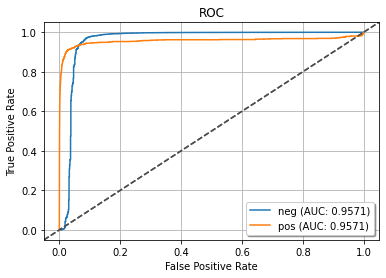

In [91]:
weka.plot.classifiers.plot_roc(eval1, class_index=[0,1],wait=True)

In [92]:
cls.build_classifier(weka_train)
weka_test_pre = []
weka_test_pro = []
for i in weka_test:
  weka_test_pre.append(cls.classify_instance(i))
  weka_test_pro.append(cls.distribution_for_instance(i))
weka_test_pre = np.array(weka_test_pre).astype('str')
weka_test_pre[weka_test_pre == '0.0'] = 'neg'
weka_test_pre[weka_test_pre == '1.0'] = 'pos'
weka_test_pro = np.array(weka_test_pro)


In [93]:
print('Confusion Matrix:')
print(confusion_matrix(aps_test.loc[:,'class'], weka_test_pre))

Confusion Matrix:
[[15589    36]
 [  110   265]]


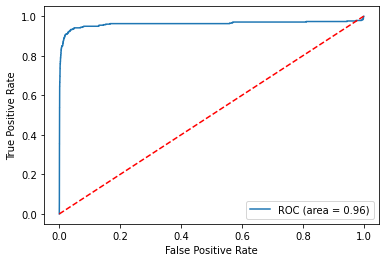

The AUC score for Test: 0.9612475733333333


In [95]:
fpr, tpr, thresholds = roc_curve(aps_test.loc[:,'class'], weka_test_pro[:,1],pos_label='pos')
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()
print('The AUC score for Test:', roc_auc)

####(f) Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance.8 Train a Logistic Model Tree using the pre-processed data and repeat 2e. Do not forget that there is a right and a wrong way of cross validation here. Compare the uncompensated case with SMOTE.

### In another jupyternotebook

### 9.7.3

#### (a)(b)(d) Sketch

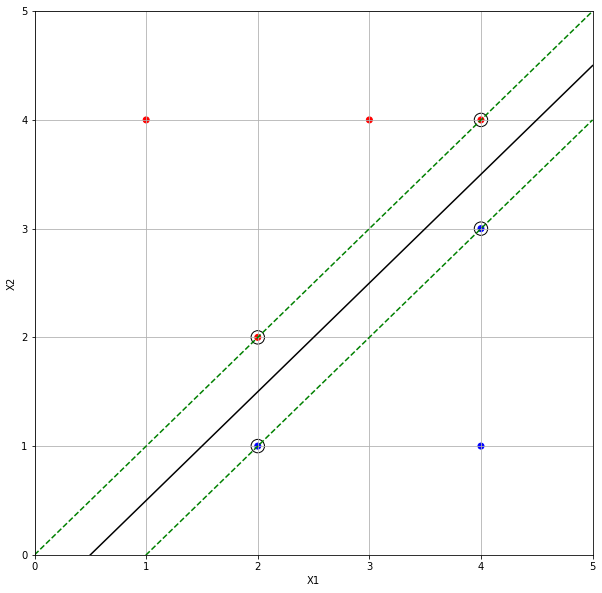

In [ ]:
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt
X = [[3, 2, 4, 1, 2, 4, 4], [4, 2, 4, 4, 1, 3, 1]]
Y = ['r', 'r', 'r', 'r', 'b', 'b', 'b']

# fit the model
clf = svm.SVC(kernel='linear', C=100)
clf.fit(np.array(X).T.tolist(), Y)

# get the separating hyperplane
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(0, 5)
yy = a * xx - (clf.intercept_[0]) / w[1]

# plot the parallels to the separating hyperplane that pass through the
# support vectors
b = clf.support_vectors_[0]
yy_down = a * xx + (b[1] - a * b[0])
b = clf.support_vectors_[-1]
yy_up = a * xx + (b[1] - a * b[0])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=180, facecolors='none', edgecolors='black')
plt.scatter(X[0], X[1], c=['r', 'r', 'r', 'r', 'b', 'b', 'b'])
plt.plot(xx, yy, 'k-')
plt.plot(xx, yy_down, 'k--', color='g')
plt.plot(xx, yy_up, 'k--', color='g')

ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.set_xlabel('X1')
ax.set_ylabel('X2')

plt.grid()
plt.show()

#### (b) Sketch the optimal separating hyperplane, and provide the equation for this hyperplane

Because the optimal separating hyperplane is the line which passes through the points (2,1.5) and (4,3.5) which equation is X1 - X2 - 0.5 = 0

#### (c) Describe the classification rule for the maximal margin classifier

In [ ]:
- (clf.intercept_[0]) / w[1]

-0.5000000000000009

In [ ]:
a

1.0

The classification rule is “Classify to Red if X1−X2−0.5<0 and classify to Blue otherwise.

#### (d) On your sketch, indicate the margin for the maximal margin hyperplane.

#### (e) Indicate the support vectors for the maximal margin classifier.

The support vectors are the points (2,1), (2,2), (4,3) and (4,4).

#### (f) Argue that a slight movement of the seventh observation would not affect the maximal margin hyperplane.

By examining the plot, it is clear that if we moved the observation (1,4), we would not change the maximal margin hyperplane as it is not a support vector.

#### (g) Sketch a hyperplane that is not the optimal separating hyperplane, and provide the equation for this hyperplane.

X1−X2−0.3=0  is not the optimal separating hyperplane.

#### (h) Draw an additional observation on the plot so that the two classes are no longer separable by a hyperplane.

Text(0, 0.5, 'X2')

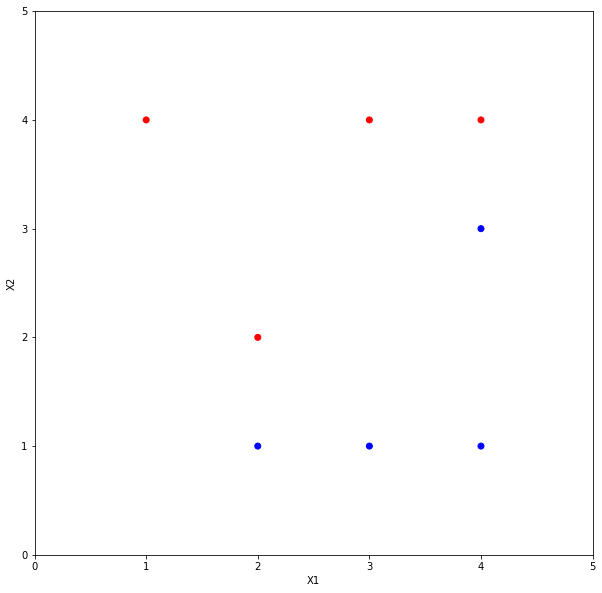

In [ ]:
X = [[3, 2, 4, 1, 2, 4, 4, 3], [4, 2, 4, 4, 1, 3, 1, 1]]
Y = ['r', 'r', 'r', 'r', 'b', 'b', 'b', 'b']
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plt.scatter(X[0], X[1], c=['r', 'r', 'r', 'r', 'b', 'b', 'b', 'b'])
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.set_xlabel('X1')
ax.set_ylabel('X2')